# Lecture 12:  Iterative methods-2

## Previous lecture
- Arnoldi orthogonalization of Krylov subspaces
- Lanczos for the symmetric case
- Energy functional and conjugate gradient method
- Convergence analysis
- Non-symmetric case: idea of GMRES

## Today lecture
- More iterative methods 
- The concept of preconditioners

## What methods to use

- If a matrix is symmetric (Hermitian) positive definite, use CG method.
- If a matrix is symmetric by indefinite, we can use MINRES method (GMRES applied to a symmetric system)
- If a matrix is non-symmetric and not very big, use GMRES
- Ia a matrix is non-symmetric and we can store limited amount of vectors, use either: GMRES with restarts, or BiCGStab (the latter of the product with $A^{\top}$ is also available).

## MINRES

The MINRES method is GMRES applied to a symmetric system. We minimize

$$\Vert A Q_j x_j - f \Vert = \Vert Q_j \widehat{x}_j + h_{j, j-1} q_j \widehat{x}_j - f \Vert = \Vert Q_{j+1} \widehat{H}_{j+1}  \widehat{x}_j - f \Vert \rightarrow \min$$

which is equivalent to a linear least squares with an **almost tridiagonal** matrix

$$\Vert \widehat{H}_{j+1} x_{j} - \gamma e_0 \Vert \rightarrow \min.$$

In a similar fashion, we can derive short-term recurrences.

A careful implementation of MINRES requires at most $5$ vectors to be stored.

## Difference between MINRES and CG
- MINRES minimizes $\Vert Ax_k - f \Vert$ over the Krylov subspace
- CG minimize $(Ax, x) - 2(f, x)$ over the Krylov subspace
- MINRES works for indefinite (i.e., non-positive definite problems).

CG stores less vectors ($3$ instead of $5$). 

Now, let us talk about non-symmetric systems.

## Non-symmetric systems
The main disadvantage of GMRES: we have to store all the vectors, so the memory cost grows with each step.  

We can do  **restarts** (i.e. get a new residual and a new Krylov subspace): we find some approximate solution $x$ 

and now solve the linear system for the correction:

$$A(x + e) = f, \quad Ae = f - Ax,$$

and generate the new **Krylov subspace** from the residual vector. This spoils the convergence, as we will see from the demo.

BiConjugate gradient (named **BiCg**, proposed by Fletcher) avoids that using "short recurrences" like in the CG method.

It is very unstable in the original form, thus a stabilized version has been proposed (named **BiCgStab**).

## Idea of biconjugate gradient

Idea of BiCG method is to use the normal equations:

$$A^* A x = A^* f,$$

and apply the CG method to it.

The condition number has squared, thus we need **stabilization**.

The stabilization idea proposed by Van der Vorst et al. improves the stability.

Let us do some demo for a simple non-symmetric matrix.

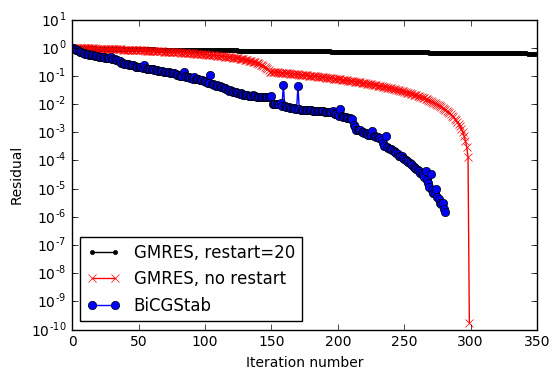

In [42]:
#### import numpy as np
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
n = 300
ex = np.ones(n);
lp1 = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ee = sp.sparse.eye(n)

#lp2 = sp.kron(lp1, ee) + sp.kron(ee, lp1)
#rhs = np.ones(n * n)
res_all = []
res_all_no = []
res_all_bicg = []
def my_print(r):
    res_all.append(r)
    
def my_print1(r):
    res_all_no.append(r)

def my_print2(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg.append(np.linalg.norm(lp1.dot(x) - rhs))
    
#res_all_bicg = np.array(res_all_bicg)
sol = scipy.sparse.linalg.gmres(lp1, rhs, restart=20, callback=my_print)
sol1 = scipy.sparse.linalg.gmres(lp1, rhs, restart=n, callback=my_print1)
sol2 = scipy.sparse.linalg.bicgstab(lp1, rhs, x0=np.zeros(n), callback=my_print2)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]

lim = 350
plt.semilogy(res_all[:lim], marker='.',color='k', label='GMRES, restart=20')
plt.semilogy(res_all_no[:lim], marker='x',color='r', label='GMRES, no restart')
plt.semilogy(res_all_bicg[:lim], label='BiCGStab', marker='o')

plt.xlabel('Iteration number')
plt.ylabel('Residual')
plt.legend(loc='best')`

## Notes about BiCG

A practical implementation of BiCG uses **two-sided Lanczos process** 

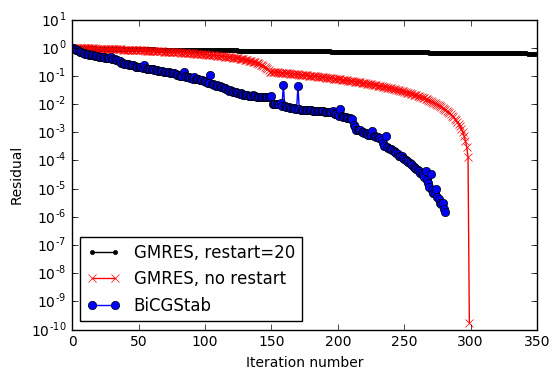

In [39]:
#### import numpy as np
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.sparse.linalg import minres, gmres
import numpy as np
import scipy as sp
n = 300
ex = np.ones(n);
lp1 = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ee = sp.sparse.eye(n)

#lp2 = sp.kron(lp1, ee) + sp.kron(ee, lp1)
#rhs = np.ones(n * n)
res_all = []
res_all_no = []
res_all_bicg = []
def my_print(r):
    res_all.append(r)
    
def my_print1(r):
    res_all_no.append(r)

def my_print2(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg.append(np.linalg.norm(lp1.dot(x) - rhs))
    
#res_all_bicg = np.array(res_all_bicg)
sol = scipy.sparse.linalg.gmres(lp1, rhs, callback=my_print)
sol1 = scipy.sparse.linalg.gmres(lp1, rhs, restart=n, callback=my_print1)
sol2 = scipy.sparse.linalg.bicgstab(lp1, rhs, x0=np.zeros(n), callback=my_print2)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]

lim = 350
plt.semilogy(res_all[:lim], marker='.',color='k', label='GMRES, restart=20')
plt.semilogy(res_all_no[:lim], marker='x',color='r', label='GMRES, no restart')
plt.semilogy(res_all_bicg[:lim], label='BiCGStab', marker='o')

plt.xlabel('Iteration number')
plt.ylabel('Residual')
plt.legend(loc='best')

##  BiConjugate Gradients

BiCG theory is nasty. Since we solve 

$$( A^* A ) x = f, $$

 there are two options. 

1. Use $K(A^* A, A^* f)$ to generate the subspace. That leads to square of condition number
2. Instead, use two Krylov subspaces $K(A)$ and $K(A^*)$ to generate two basises that are **biorthogonal** (so-called biorthogonal Lanczos).

The goal is to compute the Petrov-Galerkin projection 

$$W^* A V \widehat{x} = W^* f$$

with columns $W$ from the Krylov subspace of $A^*$, $V$ from $A$. 

That may lead to instabilities if we try to recompute the solutions in the efficient way. It is related to the **pivoting** (which we did not use in CG), and it is not naturally implemented here.

## BiCGStab

BiCGStab is frequently used, and represent a **stabilized** version of BiCG. It has faster and smoother convergence than original BiCG method.


The formulas can be found, for example, here https://en.wikipedia.org/wiki/Biconjugate_gradient_stabilized_method

It is a combination of BiCG step followed by GMRES(1) step in order to smooth the convergence.

For more detailed reading, please consult the book "Iterative Krylov Methods for Large Linear Systems" by H. Van-der Voorst.

A short demo to compare "Stabilized" vs "Non-stabilized" versions.

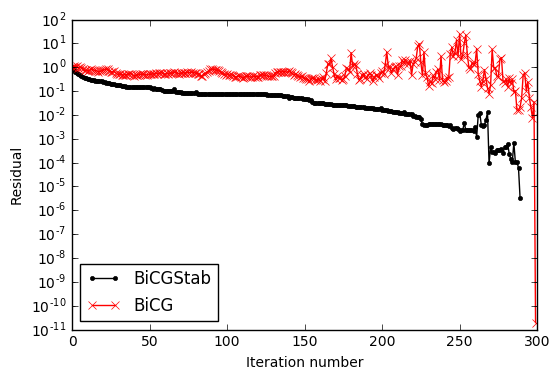

In [45]:
#### import numpy as np
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.sparse.linalg import minres, gmres
import numpy as np
import scipy as sp
n = 300
ex = np.ones(n);
lp1 = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n)
ee = sp.sparse.eye(n)

#lp2 = sp.kron(lp1, ee) + sp.kron(ee, lp1)
#rhs = np.ones(n * n)
res_all_bicg = []
res_all_bicgstab = []

def my_print3(x):
    res_all_bicg.append(np.linalg.norm(lp1.dot(x) - rhs))

def my_print2(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicgstab.append(np.linalg.norm(lp1.dot(x) - rhs))
    
#res_all_bicg = np.array(res_all_bicg)
sol2 = scipy.sparse.linalg.bicg(lp1, rhs, x0=np.zeros(n), callback=my_print3)
sol2 = scipy.sparse.linalg.bicgstab(lp1, rhs, x0=np.zeros(n), callback=my_print2)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]
res_all_bicgstab = np.array(res_all_bicgstab)/res_all_bicgstab[0]

lim = 350
plt.semilogy(res_all_bicgstab[:lim], marker='.',color='k', label='BiCGStab')
plt.semilogy(res_all_bicg[:lim], marker='x',color='r', label='BiCG')

plt.xlabel('Iteration number')
plt.ylabel('Residual')
plt.legend(loc='best')

## "Nonlinear GMRES" or Anderson acceleration

We can apply the GMRES-like idea to speed up the convergence of a given fixed-point iteration

$$x_{k+1} = \Phi(x_k).$$

This was actually older than the GMRES, and known as an Direct Inversion in Iterated Subspaces in Quantum Chemistry, or **Anderson Acceleration**.

Idea: 

**Use history** for the update, 

$$x_{k+1} = \Phi(x_k) + \sum_{s=1}^m \alpha_s (x_{k - s} - \Phi(x_{k - s})), $$

and the parameters $\alpha_s$ are selected to minimize the norm of the residual.

## Battling the condition number

The condition number problem is **un-avoidable** if only the matrix-by-vector product is used.

Thus we need an **army of preconditioners** to solve it.

There are several **general purpose** preconditioners that we can use,

but often for a particular problem a special design is needed.

## Preconditioner: general concept

The general concept of the preconditioner is simple:

Given a linear system 

$$A x = f,$$

we want to find the matrix $P_R$ (or $P_L$) such that 

1. Condition number of $AP_R^{-1}$ (right preconditioner) or $P^{-1}_LA$ (right preconditioner) or $P^{-1}_L A P_R^{-1}$ is better than for $A$
2. We can easily solve $P_Ly = g$ or $P_Ry = g$ for any $g$ (otherwise we could choose e.g. $P_L = A$)

Then we solve for (right preconditioner)

$$ AP_R^{-1} y = f \quad \Rightarrow \quad P_R x = y$$ 

or  (left preconditioner)

$$ P_L^{-1} A x = P_L^{-1}f,$$ 
or even both
$$ P_L^{-1} A P_R^{-1} y = P_L^{-1}f \quad \Rightarrow \quad P_R x = y.$$ 

The best choice is of course $P = A,$ but this does not make life easier.

One of the ideas is to use other iterative methods (beside Krylov) as preconditioners.

## Other iterative methods as preconditioners
There are other iterative methods that we have not mentioned. 

1. Jacobi method
2. Gauss-Seidel
3. SOR (Successive over-relaxation)

## Jacobi method (as preconditioner)

Consider again the matrix with non-zero diagonal. To get the **Jacobi method** is when you express the diagonal element:

$$a_{ii} x_i = -\sum_{i \ne j} a_{ij} x_j + f_i$$

and use this to iteratively update $x_i$:
$$ x_i^{(k+1)} = -\frac{1}{a_{ii}}\left( \sum_{i \ne j} a_{ij} x_j^{(k)} + f_i \right),$$
or in the matrix form
$$
x^{(k+1)} = D^{-1}\left((D-A)x^{(k)} + f\right) 
$$
where $D = \mathrm{diag}(A)$ and finally
$$
x^{(k+1)} = x^{(k)} - D^{-1}(Ax^{(k)} - f).
$$

So, Jacobi method is nothing, but simple Richardson iteration with $\tau=1$ and left preconditioner $P = D$ - diagonal of a matrix. Therefore we will refer to $P = \mathrm{diag}(A)$ as **Jacobi preconditioner**. Note that it can be used for any other method like Chebyshev or Krylov-type methods.

## Properties of the Jacobi preconditioner

Jacobi preconditioner:

1. Very easy to compute and apply
2. Works well for diagonally dominant matrices (remember the Gershgorin circle theorem!)
3. Useless if all diagonal entries are the same (proportional to the identity matrix)

## Gauss-Seidel (as preconditioner)
Another well-known method is **Gauss-Seidel method**. 

Its canonical form is very similar to the Jacobi method, with a small difference. When we update $x_i$ as

$$x_i := -\frac{1}{a_{ii}}\left( \sum_{i \ne j} a_{ij} x_j + f_i \right)$$

we **use it in the later updates**. In the Jacobi method we use the full vector from the previous iteration.

Its matrix form is more complicated.

## Gauss-Seidel: matrix version

Given $A = A^{*} > 0$ we have  

$$A = L + D + L^{*},$$

where $D$ is the diagonal of $A$, $L$ is lower-triangular part with zero on the diagonal.

One iteration of the GS method reads
$$
x^{(k+1)} = x^{(k)} - (L + D)^{-1}(Ax^{(k)} - f).
$$
and we refer to the preconditioner $P = L+D$ as **Gauss-Seidel preconditioner**.

**Good news: ** $\rho(I - (L+D)^{-1} A) < 1, $

where $\rho$ is the spectral radius,

i.e. for a positive definite matrix GS-method always converges.

## Gauss-Seidel and coordinate descent

GS-method can be viewed as a coordinate descent method, applied to the energy functional

$$F(x) = (Ax, x) - 2(f, x)$$

with the iteration 

$$x_i := \arg \min_z F(x_1, \ldots, x_{i-1}, z, x_{i+1}, \ldots, x_d).$$

Moreover, the order in which we eliminate variables, is really important!

## Side note: Nonlinear Gauss-Seidel (a.k.a coordinate descent)
If $F$ is given, and we optimize one coordinate at a time, we have


$$x_i := \arg \min_z F(x_1, \ldots, x_{i-1}, z, x_{i+1}, \ldots, x_d).$$

**Note** the convergence result for block coordinate descent for the case of a general functional $F$: 

it converges locally with the speed of the GS-method applied to the **Hessian** $$H = \nabla^2 F$$ of the functional.

Thus, if $F$ is twice differentiable and $x_*$ is the local minimum, then $H > 0$ can Gauss-Seidel converges.

## Successive overrelaxation (as preconditioner)

We can even introduce a parameter into the GS-method preconditioner, giving a **successive over-relaxation** (**SOR**) method:

$$
x^{(k+1)} = x^{(k)} - \omega (D + \omega L)^{-1}(Ax^{(k)} - f).
$$

$$P = \frac{1}{\omega}(D+\omega L).$$

Converges for $0<\omega < 2$. Optimal selection of $\omega$ is **not trivial**. Note that $\omega = 1$ gives us a Gauss-Seidel preconditioner.


## Preconditioners for sparse matrices

If $A$ is sparse, one iteration of Jacobi, GS and SOR method is cheap. 

For GS, we need to solve linear system with a sparse triangular matrix $L$, which costs $\mathcal{O}(nnz)$.

For sparse matrices, however, there are more complicated algorithms, based on the idea of **approximate** LU-decomposition.

Remember the motivation for CG: possibility of the early stopping, how to do approximate LU-decomposition for a sparse matrix? 

## Remember the Gaussian elimination
Let us remember the basic method for solving linear systems:

Decompose the matrix $A$ in the form 

$$A = P_1 L U P^{\top}_2, $$

where $P_1$ and $P_2$ are certain **permutation** matrices (which do the pivoting).

The most natural idea is to use **sparse** $L$ and $U$. 

It is not possible without **fill-in** growth for example for matrices, coming from 2D/3D Partial Differential equations (PDEs).

What to do?

## Incomplete LU


Suppose you want to eliminate a variable $x_1$,

and the equations have the form

$$5 x_1 + x_4 + x_{10} = 1, \quad 3 x_1 + x_4 + x_8 = 0, \ldots,$$

and in all other equations $x_1$ are not present. 

After the elimination, only $x_{10}$ will enter additionally to the second equation (new fill-in).

$$x_4 + x_8 + 3(1 - x_4 - x_{10})/5 = 0$$

In the Incomplete $LU$ case (actually, ILU(0)) we just throw away the **new fill-in**.

## Incomplete-LU: formal definition

We run the usual LU-decomposition cycle, but avoid inserting non-zeros **other** than the initial non-zero pattern. 

``
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    for k in range(n): #Eliminate one row   
        L[k, k] = 1
        for i in range(k+1, n):
            L[i, k] = a[i, k] / a[k, k]
            for j in range(k+1, n):
                a[i, j] = a[i, j] - L[i, k] * a[k, j]  #New fill-ins appear here
        for j in range(k, n):
            U[k, j] = a[k, j]
``

## ILU(k)

Yousef Saad (who is the author of GMRES) also had a seminal paper on the **Incomplete LU** decomposition

A good book on the topic is Saad, Yousef (1996), Iterative methods for sparse linear systems 

And he proposed **ILU(k)** method, which has a nice interpretation in terms of graphs.

## ILU(k): idea

The idea of ILU(k) is very instructive and is based on the connection between sparse matrices and graphs.

Suppose you have an $n \times n$ matrix $A$ and a corresponding adjacency graph.

Then we eliminate one variable (vertex) and get a smaller system of size $(n-1) \times (n-1)$.

New edges (=fill-in) appears between high-order neighbors.

## LU & graphs

The new edge can appear only between vertices that had common neighbour: it means, that they are second-order neigbours.  This is also a sparsity pattern of the matrix 

$$A^2.$$

The **ILU(k)** idea is to leave only the elements in $L$ and $U$ that are $k$-order neighbours in the original graph.

The ILU(2) is very efficient, but for some reason completely abandoned (i.e. there is no implementation in MATLAB and scipy).

There is an original Sparsekit software by Saad, which works quite well.

## ILU Thresholded (ILUT)
A much more popular approach is based on the so-called **thresholded LU**.

You do the standard Gaussian elimination with fill-ins, but either:

- Throw away elements that are smaller than threshold, and/or control the amount of non-zeros you are allowed to store.

- The smaller is the threshold, the better is the preconditioner, but more memory it takes.

It is denoted ILUT($\tau$).

## Symmetric positive definite case

In the SPD case, instead of incomplete LU you should use Incomplete Cholesky, which is twice faster and consumes twice less memory.

Both **ILUT** and **Ichol** are implemented in scipy and you can try (nothing quite fancy, but it works).

## Second-order LU preconditioners

There is a more efficient (but much less popular due to the limit of open-source implementations) **second-order** LU factorization [proposed by I. Kaporin](http://www.researchgate.net/profile/I_Kaporin/publication/242940993_High_quality_preconditioning_of_a_general_symmetric_positive_definite_matrix_based_on_its_UTU__UTR__RTU-decomposition/links/53f72ad90cf2888a74976f54.pdf)

The idea is to approximate the matrix in the form

$$A \approx U_2 U^{\top}_2 + U^{\top}_2 R_2 + R^{\top}_2 U_2,$$

which is just the expansion of the $UU^{\top}$ with respect to the perturbation of $U$. 

where $U_1$ and $U_2$ are low-triangular and sparse, whereare $R_2$ is small with respect to the drop tolerance parameter.



## What else?
Besides the ILU/IC approaches, there is a very efficient approach, called **algebraic multigrid (AMG)**.

It was first proposed by Ruge and Stuben in 1987.

It is probably the only **black-box** method that is asymptotically optimal for 2D/3D problems 

(at least, for elliptic problems).

The idea comes from the **geometric multigrid**.




## Multigrid: just the basic idea
The basic idea of the multigrid is to consider a set of problems on **coarser meshes** (instead of the original problem).

Then we solve a system on a coarse mesh, and interpolate it to a finer mesh.

Geometric multigrid uses the information about the meshes, operators, discretization..

AMG method tries to guess it from the **matrix**.

More in the **FastPDE course** :)

## Summary of this part

- Jacobi, Gauss-Seidel, SSOR (as preconditioners)
- Incomplete LU, three flavours: ILU(k), ILUT, ILU2

## Iterative methods for other NLA problems

Up to now, we only talked about the iterative methods for **linear systems**.

There are other important large-scale problems:

1. (Partial) Eigenvalue problem: $Ax_k = \lambda_k x_k.$
2. (Partial) SVD problem: $A v_k = \sigma_k u_k, \quad A^* u_k = \sigma_k v_k$.

**It is extremely difficult to compute all eigenvalues/singular values of a matrix**

(singular vectors / eigenvectors are not sparse, so we need to store them all!).

But it is possible to solve **partial eigenvalue problems**. 

Recall, that the SVD follows from the symmetric eigenvalue problem.

## Iterative method for eigenvalue problems

We started the journey through iterative methods from the power method to compute the eigenvector, corresponding to the largest eigenvalue.

$$x := \frac{Ax}{\Vert Ax \Vert}.$$

The solution obviously lies in the Krylov space. 

In the general symmetric case, this eigenvector maximizes the **Rayleigh quotient**

$$ x_* = \arg \max_x \frac{(Ax, x)}{(x, x)}.$$

Thus, we can try to look for the approximate solution in a subspace $Q$, and find the coefficients from the reduced eigenvalue problem

$$(Q^* A Q) \widehat{x} = \widehat{\lambda} \widehat{x},$$

with the hope that the eigenvalue of $Q^* A Q$ will converge to the eigenvalue of $A$.

The machinery is similar to linear systems.

## General Krylov scheme for eigenvalues

A general Krylov-Arnoldi-Lanczos scheme would be as follows: 

1. Generate the basis in the $j$-th Krylov subspace
2. Compute the Galerkin projection $A_j = Q^*_j A Q_j$
3. Compute (some of) the eigenvalues of $A_j$ (also called **Ritz values**) as an approximation to the eigenvalues of $A$.

## Difficulties

There are advantages/difficulties of this approach. 
- Approximation to several eigenvalues obtained simultaneouslu
- At each step we need to recompute eigenvalues/eigenvectors of a tridiagonal (in the symmetric case) matrix $A$, and there is no simple update formula, and there is no way to efficiently recompute the eigenvalue/eigenvector in an efficient way (compared to linear system)
- Thus, no robust stopping criteta is availabl


## Alternatives

As an alternative, there are several methods:

- Jacobi-Davidson
- Locally Optimal Block Conjugate Gradient 
- Inverse iteration

They focus on some of the eigenvalues and use different principles.

## Next lecture

- Eigenvalue problems in more details.

# Questions?

In [41]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()